In [83]:
#load relevant packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from pandas import DataFrame
from scipy.stats import uniform
from math import sqrt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ARMA as arma
from statsmodels.tsa.arima_model import ARIMAResults as arima_results
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from numpy import nan
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import pyplot
from datetime import datetime
from math import sqrt
from numpy import round


In [84]:
#split the files in two because github wouldn't accept such a large file. Load, append and show head.
zips_temp = pd.read_csv('https://raw.githubusercontent.com/barrettfranks/ist718/master/Zip_SFR1.csv')
zips_temp2 = pd.read_csv('https://raw.githubusercontent.com/barrettfranks/ist718/master/Zip_SFR_2.csv', sep="\t")
zips = zips_temp.append(zips_temp2, ignore_index=True)
zips.head(5)

,RegionID,SizeRank,RegionName,State,City,Metro,CountyName,1/31/97,2/28/97,3/31/97,...,6/30/19,7/31/19,8/31/19,9/30/19,10/31/19,11/30/19,12/31/19,1/31/20,2/29/20,3/31/20
0,61639,0,10025,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,NaN,...,1413747,1405862,1402547,1390420,1381621,1375725,1374714,1381453,1385737,1389268
1,84654,1,60657,IL,Chicago,Chicago-Naperville-Elgin,Cook County,376806.0,380122.0,384081.0,...,974693,975616,975734,975251,974238,973104,971908,972038,973671,975642
2,61637,2,10023,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,NaN,...,1528603,1514894,1502233,1492429,1486122,1480426,1476509,1478980,1479301,1474994
3,91982,3,77494,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,201687.0,202931.0,204207.0,...,335536,335878,335940,336092,336119,336083,336154,335860,336037,336483
4,84616,4,60614,IL,Chicago,Chicago-Naperville-Elgin,Cook County,566446.0,569659.0,573409.0,...,1207765,1208853,1208481,1206304,1204013,1201182,1198879,1198277,1199900,1200980


In [85]:
#note - because of the file size issue with github I manually deleted a few irrelevant columns
#make sure all zips have 5 digits...solve for leading zeroes 
zips['RegionName'] = zips['RegionName'].astype('str').apply(lambda x: x.zfill(5))
#drop na
zips = zips.dropna()

In [86]:
zips.describe()

,RegionID,SizeRank,1/31/97,2/28/97,3/31/97,4/30/97,5/31/97,6/30/97,7/31/97,8/31/97,...,6/30/19,7/31/19,8/31/19,9/30/19,10/31/19,11/30/19,12/31/19,1/31/20,2/29/20,3/31/20
count,12652.000000,12652.000000,1.265200e+04,1.265200e+04,1.265200e+04,1.265200e+04,1.265200e+04,1.265200e+04,1.265200e+04,1.265200e+04,...,1.265200e+04,1.265200e+04,1.265200e+04,1.265200e+04,1.265200e+04,1.265200e+04,1.265200e+04,1.265200e+04,1.265200e+04,1.265200e+04
mean,79520.249684,10487.963721,1.364534e+05,1.368703e+05,1.373016e+05,1.377571e+05,1.382175e+05,1.386737e+05,1.391666e+05,1.396242e+05,...,3.298740e+05,3.305269e+05,3.312726e+05,3.321573e+05,3.330769e+05,3.340188e+05,3.351492e+05,3.364669e+05,3.379770e+05,3.395673e+05
std,32516.832690,8031.507297,9.390761e+04,9.443318e+04,9.495935e+04,9.531324e+04,9.574706e+04,9.620741e+04,9.677396e+04,9.735671e+04,...,3.426109e+05,3.427776e+05,3.430599e+05,3.437730e+05,3.445070e+05,3.453741e+05,3.468322e+05,3.488132e+05,3.512563e+05,3.536515e+05
min,58059.000000,1.000000,1.003700e+04,1.003600e+04,1.003500e+04,9.994000e+03,9.926000e+03,9.947000e+03,1.003000e+04,1.011400e+04,...,1.788800e+04,1.840600e+04,1.886200e+04,1.917600e+04,1.955400e+04,1.988800e+04,2.031300e+04,2.032300e+04,2.014600e+04,1.999000e+04
25%,65083.250000,3992.500000,7.961700e+04,7.976225e+04,8.004425e+04,8.018800e+04,8.044150e+04,8.072850e+04,8.098325e+04,8.128175e+04,...,1.514495e+05,1.518800e+05,1.526038e+05,1.531300e+05,1.537688e+05,1.543180e+05,1.548978e+05,1.554162e+05,1.559435e+05,1.566565e+05
50%,74566.500000,8595.500000,1.161285e+05,1.165190e+05,1.168435e+05,1.171810e+05,1.175735e+05,1.178705e+05,1.181930e+05,1.185645e+05,...,2.396205e+05,2.404355e+05,2.411935e+05,2.421480e+05,2.429005e+05,2.434325e+05,2.442480e+05,2.452705e+05,2.463415e+05,2.474735e+05
75%,90315.250000,15326.250000,1.674278e+05,1.678210e+05,1.682070e+05,1.689070e+05,1.692795e+05,1.696812e+05,1.701465e+05,1.707152e+05,...,3.810928e+05,3.817665e+05,3.826455e+05,3.840242e+05,3.850605e+05,3.861895e+05,3.872448e+05,3.886738e+05,3.904022e+05,3.918785e+05
max,753844.000000,34430.000000,3.108947e+06,3.138019e+06,3.138945e+06,3.112536e+06,3.095231e+06,3.088762e+06,3.109120e+06,3.153135e+06,...,7.240921e+06,7.269144e+06,7.242754e+06,7.182818e+06,7.129752e+06,7.080063e+06,7.076118e+06,7.082178e+06,7.077934e+06,7.048943e+06


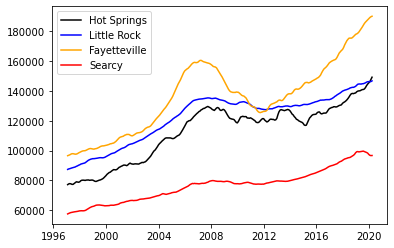

In [87]:
#define graphical inputs for Hot Springs, Little Rock, Fayetteville & Searcy
hot_springs = zips.loc[(zips['State']=='AR') & (zips['Metro'].str.contains('Hot Springs'))] 
hot_springs_mean = hot_springs.iloc[:, 7:].mean(axis=0)
hot_springs_mean.index = pd.to_datetime(hot_springs_mean.index)

little_rock = zips.loc[(zips['State']=='AR') & (zips['Metro'].str.contains('Little Rock'))]
little_rock_mean = little_rock.iloc[:, 7:].mean(axis=0)
little_rock_mean.index = pd.to_datetime(little_rock_mean.index)

fayetteville = zips.loc[(zips['State']=='AR') & (zips['Metro'].str.contains('Fayetteville'))]
fayetteville_mean = fayetteville.iloc[:, 7:].mean(axis=0)
fayetteville_mean.index = pd.to_datetime(fayetteville_mean.index)

searcy = zips.loc[(zips['State']=='AR') & (zips['Metro'].str.contains('Searcy'))]
searcy_mean = searcy.iloc[:, 7:].mean(axis=0)
searcy_mean.index = pd.to_datetime(searcy_mean.index)

#plot above values
plt.plot(hot_springs_mean.index, hot_springs_mean.values, color='black', label='Hot Springs')
plt.plot(little_rock_mean.index, little_rock_mean.values, color='blue', label='Little Rock')
plt.plot(fayetteville_mean.index, fayetteville_mean.values, color='orange', label='Fayetteville')
plt.plot(searcy_mean.index, searcy_mean.values, color='red', label='Searcy')
plt.legend()
plt.show()

In [88]:
#list(zips.columns)

In [89]:
#set training data 97 through 17
train_zip = zips.loc[:, '1/31/97':'12/31/17']
train_zip.columns = pd.to_datetime(train_zip.columns)

#set test data for 2018
zip_test_2018 = zips.loc[:, '1/31/18':'12/31/18']
zip_test_2018.columns = pd.to_datetime(zip_test_2018.columns)

#create predictions
prediction_2018 = pd.DataFrame(zip_test_2018)
prediction_2018.fillna(nan, inplace=True)

In [90]:
zip_mean = train_zip.mean(axis=0)

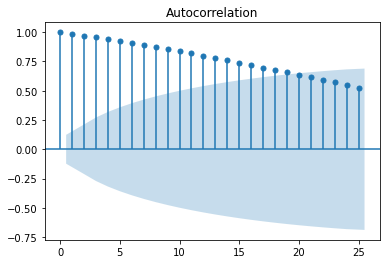

In [102]:
#visualize auto-correlation function
plot_acf(zip_mean)
pyplot.show()

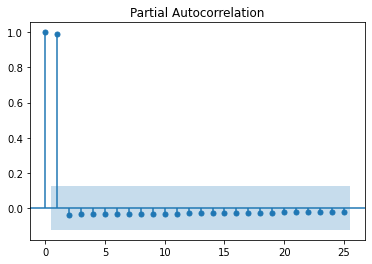

In [92]:
#visualize partial auto-correlation function
plot_pacf(zip_mean)
pyplot.show()

In [93]:
#trimming the data set to make a more reasonable run time for the model
zips_trim = zips[:5000] 

In [94]:
zips_trim.head(5)

,RegionID,SizeRank,RegionName,State,City,Metro,CountyName,1/31/97,2/28/97,3/31/97,...,6/30/19,7/31/19,8/31/19,9/30/19,10/31/19,11/30/19,12/31/19,1/31/20,2/29/20,3/31/20
1,84654,1,60657,IL,Chicago,Chicago-Naperville-Elgin,Cook County,376806.0,380122.0,384081.0,...,974693,975616,975734,975251,974238,973104,971908,972038,973671,975642
3,91982,3,77494,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,201687.0,202931.0,204207.0,...,335536,335878,335940,336092,336119,336083,336154,335860,336037,336483
4,84616,4,60614,IL,Chicago,Chicago-Naperville-Elgin,Cook County,566446.0,569659.0,573409.0,...,1207765,1208853,1208481,1206304,1204013,1201182,1198879,1198277,1199900,1200980
5,91940,5,77449,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,97543.0,97263.0,97003.0,...,184389,185268,185951,186457,187057,187978,188925,189522,190210,191469
7,91733,7,77084,TX,Houston,Houston-The Woodlands-Sugar Land,Harris County,96895.0,96481.0,96141.0,...,182153,182842,183402,183817,184460,185299,186196,186740,187491,188738


In [95]:
#re-run test/predictions with trimmed dataset
#set training data 97 through 17
train_zip = zips_trim.loc[:, '1/31/97':'12/31/17']
train_zip.columns = pd.to_datetime(train_zip.columns)

#set test data for 2018
zip_test_2018 = zips_trim.loc[:, '1/31/18':'12/31/18']
zip_test_2018.columns = pd.to_datetime(zip_test_2018.columns)

#create predictions
prediction_2018 = pd.DataFrame(zip_test_2018)
prediction_2018.fillna(nan, inplace=True)

In [96]:
zip_mean = train_zip.mean(axis=0)

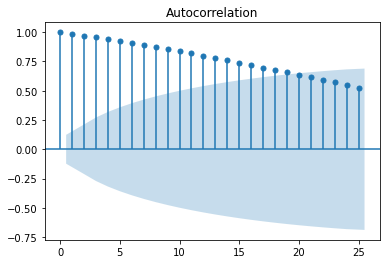

In [97]:
#visualize auto-correlation function
plot_acf(zip_mean)
pyplot.show()

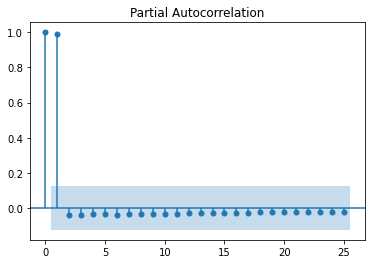

In [98]:
#visualize partial auto-correlation function
plot_pacf(zip_mean)
pyplot.show()

In [99]:
#create ARMA model for the trimmed zip file
for i in train_zip.index:
  zip_train_model = train_zip.loc[i]
  try:
    model = arima(zip_train_model, order=(2, 0, 0))
    model_fit = model.fit()
  except:
    pass
  else:
    prediction_2018.loc[i] = model_fit.predict(start='1/31/18', end='12/31/18').apply(lambda x: round(x, 1))
  finally:
    prediction_2018.dropna(axis=0, how='any', inplace=True)

In [101]:
#predict the top three zip codes for SREIT
growth_rate = pd.DataFrame(index=prediction_2018.index, columns=['Growth Rate', 'Zip', 'City'])
for i in prediction_2018.index:
  predict = round(prediction_2018.loc[i].mean(), 1)
  actual = round(zip_test_2018.loc[i].mean(), 1)
  growth_rate.loc[i, 'Growth Rate'] = round(abs(predict - actual) / actual * 100, 1)
  growth_rate.loc[i, 'Zip'] = zips_trim.loc[i, 'RegionName']
  growth_rate.loc[i, 'City'] = zips_trim.loc[i, 'City']

growth_rate.sort_values('Growth Rate', ascending=False).iloc[0:3]

,Growth Rate,Zip,City
5453,550.3,94085,Sunnyvale
648,550.0,94086,Sunnyvale
2748,548.1,94043,Mountain View


In [ ]:
"""
According to the model's predictions the top three zips using 5000 samples are:
94085 - Sunnyvale
94086 - Sunnyvale
94043 - Mountain View

This is using historical data and strong growth rates to indicate potential for future opportunities
"""

In [ ]:
"""
Sources:
files.zillowstatic.com/research/public/Zip/Zip_Zhvi_SingleFamilyResidence.csv
https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python
https://medium.com/@feraguilari/time-series-analysis-modfinalproyect-b9fb23c28309
"""